<a href="https://colab.research.google.com/github/espickle1/esmfold_colabfold/blob/main/ESMFold_ColabFold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### Colabfold running ESMFold

In [1]:
## Install necessary packages
%%time
version = "1"
model_name = "esmfold_v0.model" if version == "0" else "esmfold.model"

import os, time

if not os.path.isfile(model_name):
  # download esmfold params
  os.system("apt-get install aria2 -qq")
  os.system(f"aria2c -q -x 16 https://colabfold.steineggerlab.workers.dev/esm/{model_name} &")

  if not os.path.isfile("finished_install"):
    # install libs
    print("installing libs...")
    os.system("pip install -q omegaconf pytorch_lightning biopython ml_collections einops py3Dmol modelcif")
    os.system("pip install -q git+https://github.com/NVIDIA/dllogger.git")

    print("installing openfold...")
    # install openfold
    os.system(f"pip install -q git+https://github.com/sokrypton/openfold.git")

    print("installing esmfold...")
    # install esmfold
    os.system(f"pip install -q git+https://github.com/sokrypton/esm.git")
    os.system("touch finished_install")

  # wait for Params to finish downloading...
  while not os.path.isfile(model_name):
    time.sleep(5)
  if os.path.isfile(f"{model_name}.aria2"):
    print("downloading params...")
  while os.path.isfile(f"{model_name}.aria2"):
    time.sleep(5)

installing libs...
installing openfold...
installing esmfold...
CPU times: user 600 ms, sys: 74 ms, total: 674 ms
Wall time: 3min 45s


In [3]:
## Import dependencies
%%time
import torch
from jax.tree_util import tree_map
import gc

from string import ascii_uppercase, ascii_lowercase
import hashlib, re, os
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import softmax
import py3Dmol

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
CPU times: user 426 ms, sys: 87.9 ms, total: 514 ms
Wall time: 6.95 s


In [5]:
## Parsing outputs
def parse_output(output):
  pae = (output["aligned_confidence_probs"][0] * np.arange(64)).mean(-1) * 31
  plddt = output["plddt"][0,:,1]

  bins = np.append(0,np.linspace(2.3125,21.6875,63))
  sm_contacts = softmax(output["distogram_logits"],-1)[0]
  sm_contacts = sm_contacts[...,bins<8].sum(-1)
  xyz = output["positions"][-1,0,:,1]
  mask = output["atom37_atom_exists"][0,:,1] == 1
  o = {"pae":pae[mask,:][:,mask],
       "plddt":plddt[mask],
       "sm_contacts":sm_contacts[mask,:][:,mask],
       "xyz":xyz[mask]}
  return o

def get_hash(x): return hashlib.sha1(x.encode()).hexdigest()
alphabet_list = list(ascii_uppercase+ascii_lowercase)

In [6]:
## Load model
if "model" not in dir() or model_name != model_name_:
  if "model" in dir():
    # delete old model from memory
    del model
    gc.collect()
    if torch.cuda.is_available():
      torch.cuda.empty_cache()

  model = torch.load(model_name)
  model.eval().cuda().requires_grad_(False)
  model_name_ = model_name

<ipython-input-6-7ded6d56cced>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_name)


In [7]:
## Import as a function
def sequence_read(sequence_input, position, copies):
  sequence = sequence_input.loc[position]['Translation']
  sequence_clean = re.sub("[^A-Z:]", "", sequence.replace("/",":").upper())
  sequence_clean = re.sub(":+",":",sequence)
  sequence_clean = re.sub("^[:]+","",sequence)
  sequence_clean = re.sub("[:]+$","",sequence)

  if copies == "" or copies <= 0: copies = 1
  sequence = ":".join([sequence] * copies)

  ID = jobname+"_"+get_hash(sequence)[:5]
  seqs = sequence.split(":")
  lengths = [len(s) for s in seqs]
  length = sum(lengths)
  print("length",length)

  u_seqs = list(set(seqs))
  if len(seqs) == 1: mode = "mono"
  elif len(u_seqs) == 1: mode = "homo"
  else: mode = "hetero"

  return sequence_clean, copies, ID, u_seqs, length, lengths

In [20]:
def prediction_block(sequence, ID):
  length = len(sequence)
  if length > 700:
    model.set_chunk_size(64)
  else:
    model.set_chunk_size(128)

  torch.cuda.empty_cache()
  output = model.infer(
      sequence,
      num_recycles=num_recycles,
      chain_linker="X"*chain_linker,
      residue_index_offset=512
      )

  pdb_str = model.output_to_pdb(output)[0]
  output = tree_map(lambda x: x.cpu().numpy(), output)
  ptm = output["ptm"][0]
  plddt = output["plddt"][0,...,1].mean()
  O = parse_output(output)
  print(f'ptm: {ptm:.3f} plddt: {plddt:.3f}')

  os.system(f"mkdir -p {ID}")
  prefix = f"{ID}/ptm{ptm:.3f}_r{num_recycles}_default"
  np.savetxt(f"{prefix}.pae.txt",O["pae"],"%.3f")
  with open(f"{prefix}.pdb","w") as out:
    out.write(pdb_str)

  return pdb_str, prefix, O

In [13]:
## Import settings: manual settings
num_recycles = 3
chain_linker = 25
multimer_n = 1
row_number = 2

jobname = "test1"
jobname = re.sub(r'\W+', '', jobname)[:50]

file_path = "/content/drive/MyDrive/ww_virome/esmfold_colab/sequences/big_merge_norovirus_translation.csv"
sequence_file = pd.read_csv(file_path)

meta = sequence_file.loc[row_number]['meta']
sequence = sequence_file.loc[row_number]['Translation']
print(meta)
print(f"sequence: {sequence}")
print(f"sequence length: {len(sequence)}")

AGX01093.1_Norovirus Hu/GI.2/Jingzhou/2013401/CHN_minor capsid protein VP2
sequence: MAQAIIGAIAASAAGSALGAGIQAGAEAALQSQRYQQDLALQRNTFEHDKDMLSYQVQASNALLAKNLNTRYSMLVAGGLSSADASRAVAGAPVTQLIDWNGTRVAAPRSSATTLRSGGFMAVPMPVQPKSKALQSSGFSNPAYDTSTVSSRTSSWVQSQNSLRSVSPFHRQALQTVWVTPPGSTSSSSVSSTPYGVFNTDRMPLFANLRR
sequence length: 211


In [21]:
%%time
sequence_clean, copies, ID, u_seqs, length, lengths = sequence_read(sequence_file, 1, copies=multimer_n)
pdb_str, prefix, O = prediction_block(sequence_clean, ID)

length 268
ptm: 0.304 plddt: 53.267
CPU times: user 12.7 s, sys: 207 ms, total: 12.9 s
Wall time: 12.9 s


In [22]:
## Color display

pymol_color_list = ["#33ff33","#00ffff","#ff33cc","#ffff00","#ff9999","#e5e5e5","#7f7fff","#ff7f00",
                    "#7fff7f","#199999","#ff007f","#ffdd5e","#8c3f99","#b2b2b2","#007fff","#c4b200",
                    "#8cb266","#00bfbf","#b27f7f","#fcd1a5","#ff7f7f","#ffbfdd","#7fffff","#ffff7f",
                    "#00ff7f","#337fcc","#d8337f","#bfff3f","#ff7fff","#d8d8ff","#3fffbf","#b78c4c",
                    "#339933","#66b2b2","#ba8c84","#84bf00","#b24c66","#7f7f7f","#3f3fa5","#a5512b"]

def show_pdb(pdb_str, show_sidechains=False, show_mainchains=False,
             color="pLDDT", chains=None, vmin=50, vmax=90,
             size=(800,480), hbondCutoff=4.0,
             Ls=None,
             animate=False):

  if chains is None:
    chains = 1 if Ls is None else len(Ls)
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js', width=size[0], height=size[1])
  if animate:
    view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  else:
    view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  if color == "pLDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':vmin,'max':vmax}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                  {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  view.zoomTo()
  if animate: view.animate()
  return view

color = "confidence"
if color == "confidence": color = "pLDDT"
show_sidechains = False
show_mainchains = False
show_pdb(pdb_str, color=color,
         show_sidechains=show_sidechains,
         show_mainchains=show_mainchains,
         Ls=lengths).show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

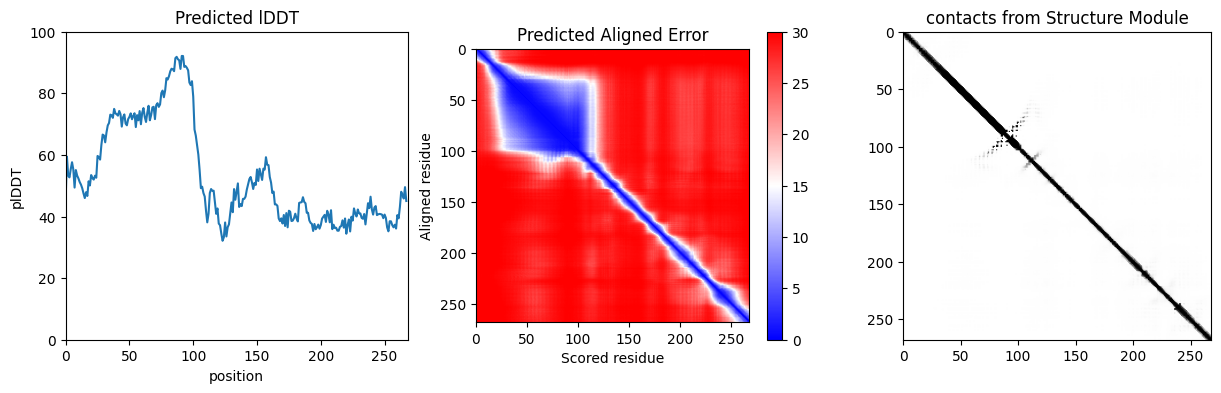

In [23]:
## Plot confidence

dpi = 100

def plot_ticks(Ls):
  Ln = sum(Ls)
  L_prev = 0
  for L_i in Ls[:-1]:
    L = L_prev + L_i
    L_prev += L_i
    plt.plot([0,Ln],[L,L],color="black")
    plt.plot([L,L],[0,Ln],color="black")
  ticks = np.cumsum([0]+Ls)
  ticks = (ticks[1:] + ticks[:-1])/2
  plt.yticks(ticks,alphabet_list[:len(ticks)])

def plot_confidence(O, Ls=None, dpi=100):
  if "lm_contacts" in O:
    plt.figure(figsize=(20,4), dpi=dpi)
    plt.subplot(1,4,1)
  else:
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.subplot(1,3,1)

  plt.title('Predicted lDDT')
  plt.plot(O["plddt"])
  if Ls is not None:
    L_prev = 0
    for L_i in Ls[:-1]:
      L = L_prev + L_i
      L_prev += L_i
      plt.plot([L,L],[0,100],color="black")
  plt.xlim(0,O["plddt"].shape[0])
  plt.ylim(0,100)
  plt.ylabel('plDDT')
  plt.xlabel('position')
  plt.subplot(1,4 if "lm_contacts" in O else 3,2)

  plt.title('Predicted Aligned Error')
  Ln = O["pae"].shape[0]
  plt.imshow(O["pae"],cmap="bwr",vmin=0,vmax=30,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  plt.colorbar()
  plt.xlabel('Scored residue')
  plt.ylabel('Aligned residue')

  if "lm_contacts" in O:
    plt.subplot(1,4,3)
    plt.title("contacts from LM")
    plt.imshow(O["lm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
    if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
    plt.subplot(1,4,4)
  else:
    plt.subplot(1,3,3)
  plt.title("contacts from Structure Module")
  plt.imshow(O["sm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  return plt

plot_confidence(O, Ls=lengths, dpi=dpi)
plt.savefig(f'{prefix}.png',bbox_inches='tight')
plt.show()